In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_path = './data/ES_Trades.csv'
data = pd.read_csv(data_path)
data

,Symbol,Date,Time,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price
0,ESU13,09/01/2013,17:00:00.083,1640.25,8,E,0,NaN,1640.25
1,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
2,ESU13,09/01/2013,17:00:00.083,1640.25,2,E,0,NaN,1640.25
3,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
4,ESU13,09/01/2013,17:00:00.083,1640.25,1,E,0,NaN,1640.25
...,...,...,...,...,...,...,...,...,...
5454945,ESZ13,09/20/2013,16:14:58.922,1703.50,7,E,0,NaN,1703.50
5454946,ESZ13,09/20/2013,16:14:58.922,1703.50,3,E,0,NaN,1703.50
5454947,ESZ13,09/20/2013,16:14:58.945,1703.75,1,E,0,NaN,1703.75
5454948,ESZ13,09/20/2013,16:14:59.111,1703.75,1,E,0,NaN,1703.75


In [3]:
class Preprocess:
    def create_date_time(data):
        """
        prepocess the date time format into 'Date_Time' one column
        :data: data include 'Date' and 'Time' two columns
        :return: data with 'Date_Time' column recording the time stamp
        """ 
        data['Date_Time'] = data['Date'] + ' ' + data['Time']
        data = data.drop(['Date', 'Time'], axis=1)
        return data 

    def create_transaction(data):
        """
        calculate the transaction value 
        :data: data include 'Price' and 'Volume' two columns
        :return: data with 'Transaction' column
        """ 
        data['Transaction'] = data['Price'] * data['Volume']
        return data
    
data = Preprocess.create_date_time(data)
data = Preprocess.create_transaction(data)
data

,Symbol,Price,Volume,Market Flag,Sales Condition,Exclude Record Flag,Unfiltered Price,Date_Time,Transaction
0,ESU13,1640.25,8,E,0,NaN,1640.25,09/01/2013 17:00:00.083,13122.00
1,ESU13,1640.25,1,E,0,NaN,1640.25,09/01/2013 17:00:00.083,1640.25
2,ESU13,1640.25,2,E,0,NaN,1640.25,09/01/2013 17:00:00.083,3280.50
3,ESU13,1640.25,1,E,0,NaN,1640.25,09/01/2013 17:00:00.083,1640.25
4,ESU13,1640.25,1,E,0,NaN,1640.25,09/01/2013 17:00:00.083,1640.25
...,...,...,...,...,...,...,...,...,...
5454945,ESZ13,1703.50,7,E,0,NaN,1703.50,09/20/2013 16:14:58.922,11924.50
5454946,ESZ13,1703.50,3,E,0,NaN,1703.50,09/20/2013 16:14:58.922,5110.50
5454947,ESZ13,1703.75,1,E,0,NaN,1703.75,09/20/2013 16:14:58.945,1703.75
5454948,ESZ13,1703.75,1,E,0,NaN,1703.75,09/20/2013 16:14:59.111,1703.75


In [4]:
class GetBarFromData():
    
    def __init__(self, data, units, bar_type='tick'):
        self.data=data.copy()
        self.units=units
        self.bar_type=bar_type
        
    def extract_data(self, data):
        """
        extract the data has been groupped
        :data: data has been groupped and groupped name is 'Group'
        :return: the wanted bar data
        """ 
        date_time = data[['Date_Time', 'Group']].groupby('Group')['Date_Time'].last()
        ohlc = data[['Price', 'Group']].astype(float).groupby('Group')['Price'].ohlc()
        volume = data[['Volume', 'Group']].astype(float).groupby('Group').sum()
        vwap = pd.DataFrame(data[['Transaction', 'Group']].astype(float).groupby('Group').sum().values / volume.values)

        bars = pd.concat([date_time, ohlc, volume, vwap], axis=1)
        bars.columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'vwap']
        return bars
    
    def tick_bars(self):
        # Create groups based on units of tick
        self.data['Group'] = self.data.index//self.units
        return self.extract_data(self.data)
    
    def volume_bars(self):
        # Create groups based on units of volumes
        assign_group = 0
        cul_volume = 0
        groups = []
        rows_volumes = list(data['Volume']) # avoid using iterrows
        for row in rows_volumes:
            if cul_volume + row < self.units:
                groups.append(assign_group)
                cul_volume += row
            else:
                cul_volume = row
                assign_group += 1
                groups.append(assign_group)
                
        self.data['Group']=groups
        
        return self.extract_data(self.data)
    
    def dollar_bars(self):
        # Create groups based on units of dollar
        assign_group = 0
        cul_volume = 0
        groups = []
        rows_volumes = list(data['Transaction']) # avoid using iterrows
        for row in rows_volumes:
            if cul_volume + row < self.units:
                groups.append(assign_group)
                cul_volume += row
            else:
                cul_volume = row
                assign_group += 1
                groups.append(assign_group)
                
        self.data['Group']=groups
        
        return self.extract_data(self.data)
    
    def get_bars(self):
        if self.bar_type == 'tick':
            bars = self.tick_bars()
        elif self.bar_type == 'volume':
            bars = self.volume_bars()
        elif self.bar_type == 'dollar':
            bars = self.dollar_bars()
        else:
            raise ValueError('Type must be: tick, volume, dollar, or time')
        return bars
        

In [5]:
tick_bars = GetBarFromData(data, 5000, 'tick').get_bars()
tick_bars

,date,open,high,low,close,volume,vwap
0.0,09/01/2013 18:17:57.413,1640.25,1642.00,1639.00,1641.00,21548.0,1640.665131
1.0,09/01/2013 20:44:56.346,1641.00,1643.50,1639.75,1642.50,16935.0,1641.851033
2.0,09/02/2013 01:00:34.717,1642.50,1644.00,1640.25,1643.00,14520.0,1642.265100
3.0,09/02/2013 02:08:37.675,1643.00,1644.50,1642.25,1643.50,13737.0,1643.681990
4.0,09/02/2013 02:40:34.175,1643.50,1646.00,1642.75,1645.25,14970.0,1644.572027
...,...,...,...,...,...,...,...
1086.0,09/20/2013 14:59:58.033,1703.25,1703.50,1702.25,1702.25,35399.0,1702.831641
1087.0,09/20/2013 15:00:21.474,1702.25,1703.25,1701.50,1702.75,48630.0,1702.636896
1088.0,09/20/2013 15:03:43.157,1702.75,1703.00,1701.25,1701.50,34593.0,1701.938116
1089.0,09/20/2013 15:10:40.225,1701.50,1703.25,1701.25,1702.75,32097.0,1702.404703


In [6]:
volume_bars = GetBarFromData(data, 5000, 'volume').get_bars()
volume_bars

,date,open,high,low,close,volume,vwap
0.0,09/01/2013 17:01:45.991,1640.25,1641.00,1639.00,1640.00,4998.0,1639.974890
1.0,09/01/2013 17:11:38.099,1640.00,1642.00,1639.50,1640.50,4993.0,1640.629281
2.0,09/01/2013 17:33:47.280,1640.75,1641.50,1639.50,1641.50,4918.0,1640.376220
3.0,09/01/2013 18:04:52.275,1641.50,1642.00,1640.50,1641.50,4996.0,1641.542834
4.0,09/01/2013 19:11:34.236,1641.50,1641.75,1639.75,1641.00,4997.0,1640.719332
...,...,...,...,...,...,...,...
4354.0,09/20/2013 15:14:27.763,1703.25,1703.25,1702.25,1702.25,4997.0,1702.715579
4355.0,09/20/2013 15:14:53.977,1702.25,1702.50,1702.00,1702.50,4971.0,1702.409576
4356.0,09/20/2013 15:33:27.405,1702.50,1704.00,1702.25,1704.00,4952.0,1703.144235
4357.0,09/20/2013 15:48:24.092,1704.00,1704.50,1703.25,1703.50,4975.0,1703.999799


In [7]:
dollar_bars = GetBarFromData(data, 35638840, 'dollar').get_bars()
dollar_bars

,date,open,high,low,close,volume,vwap
0.0,09/01/2013 18:18:58.662,1640.25,1642.00,1639.00,1641.25,21722.0,1640.667273
1.0,09/01/2013 21:42:07.388,1641.25,1643.50,1639.75,1640.75,21706.0,1641.830116
2.0,09/02/2013 02:05:25.233,1640.75,1644.50,1640.50,1644.50,21652.0,1643.149905
3.0,09/02/2013 03:01:43.942,1644.50,1646.00,1642.75,1645.00,21662.0,1644.555893
4.0,09/02/2013 04:31:45.347,1645.00,1647.25,1644.25,1645.25,21650.0,1646.011097
...,...,...,...,...,...,...,...
1019.0,09/20/2013 15:02:10.213,1702.75,1703.00,1701.50,1701.50,20932.0,1702.016792
1020.0,09/20/2013 15:04:34.454,1701.75,1702.25,1701.25,1702.25,20921.0,1701.754780
1021.0,09/20/2013 15:09:59.029,1702.25,1703.00,1702.00,1703.00,20932.0,1702.574002
1022.0,09/20/2013 15:14:50.942,1703.00,1703.25,1702.00,1702.50,20897.0,1702.862947


In [8]:
tick_bars.index = pd.to_datetime(tick_bars['date'])
volume_bars.index = pd.to_datetime(volume_bars['date'])
dollar_bars.index = pd.to_datetime(dollar_bars['date'])

In [9]:
tick_count = tick_bars['close'].resample('W', label='right').count()
volume_count = volume_bars['close'].resample('W', label='right').count()
dollar_count = dollar_bars['close'].resample('W', label='right').count()

count_df = pd.concat([tick_count, volume_count, dollar_count], axis=1)
count_df.columns = ['tick', 'volume', 'dollar']

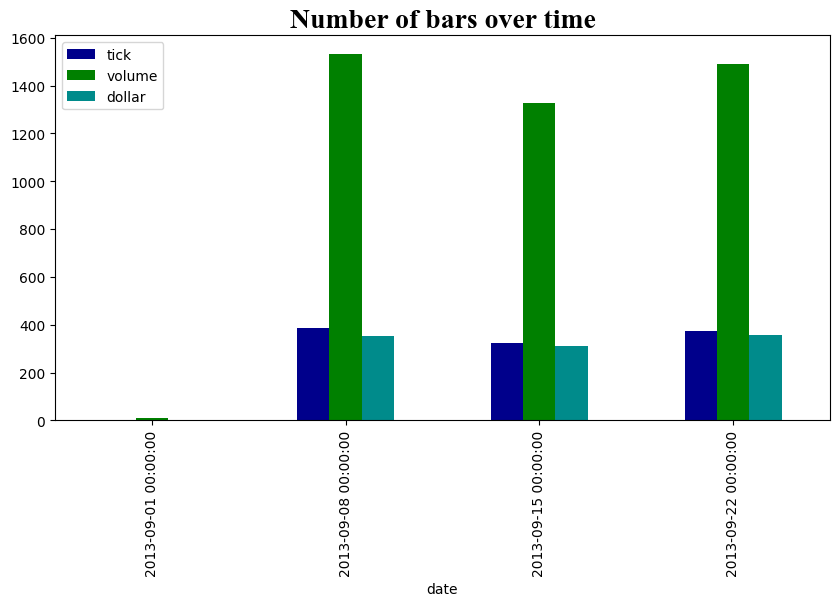

In [10]:

count_df.plot(kind='bar', figsize=[10, 5], color=('darkblue', 'green', 'darkcyan'))
plt.title('Number of bars over time', loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.show()

In [11]:
tick_returns = np.log(tick_bars['close']).diff().dropna()
volume_returns = np.log(volume_bars['close']).diff().dropna()
dollar_returns = np.log(dollar_bars['close']).diff().dropna()

/var/folders/dt/_85w7mvd1h5ff3x6kqwzbd3w0000gn/T/ipykernel_4753/1857126146.py:11: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(tick_standard, label="Tick", bw=0.25, color='darkblue')
/var/folders/dt/_85w7mvd1h5ff3x6kqwzbd3w0000gn/T/ipykernel_4753/1857126146.py:12: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='green')
/var/folders/dt/_85w7mvd1h5ff3x6kqwzbd3w0000gn/T/ipykernel_4753/1857126146.py:13: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.25`, but please see the docs for the new 

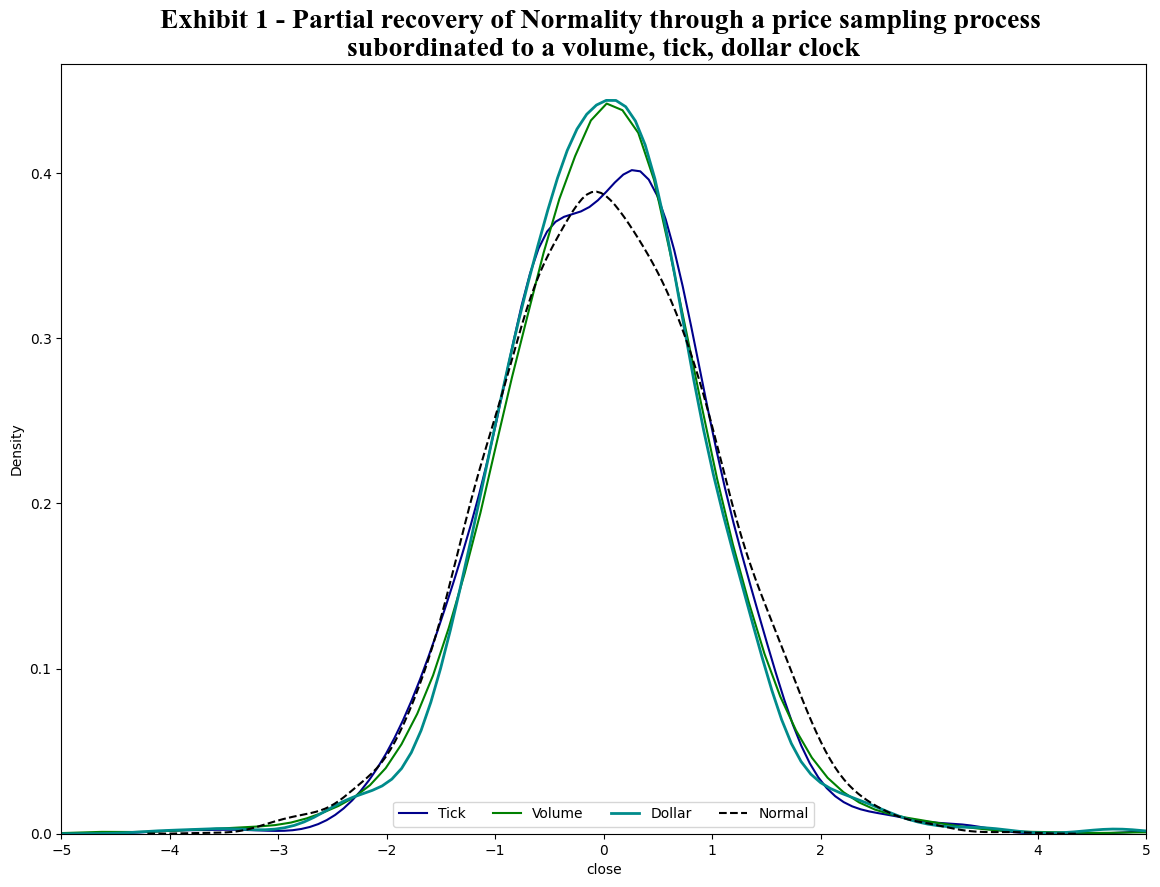

In [12]:


tick_diff = tick_returns
volume_diff = volume_returns
dollar_diff = dollar_returns

tick_standard = (tick_diff - tick_diff.mean()) / tick_diff.std()
volume_standard = (volume_diff - volume_diff.mean()) / volume_diff.std()
dollar_standard = (dollar_diff - dollar_diff.mean()) / dollar_diff.std()

# Plot the Distributions
plt.figure(figsize=(14,10))
sns.kdeplot(tick_standard, label="Tick", bw=0.25, color='darkblue')
sns.kdeplot(volume_standard, label="Volume", bw=0.25, color='green')
sns.kdeplot(dollar_standard, label="Dollar", bw=0.25, linewidth=2, color='darkcyan')

sns.kdeplot(np.random.normal(size=len(volume_returns)), label="Normal", color='black', linestyle="--")

plt.xticks(range(-5, 6))
plt.legend(loc=8, ncol=5)
plt.title('Exhibit 1 - Partial recovery of Normality through a price sampling process \nsubordinated to a volume, tick, dollar clock',
          loc='center', fontsize=20, fontweight="bold", fontname="Times New Roman")
plt.xlim(-5, 5)
plt.show()